In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
from pathlib import Path
import numpy as np
import yaml

import torch
from torchsummary import summary
from pytorch_lightning.trainer import seed_everything

from turboflow.models.phyrff import plDivFreeRFFNet
from turboflow.dataloaders import TurboFlowDataModule
from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch

import matplotlib.pyplot as plt

In [3]:
base_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','recipes','time_cnn')
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
fig_path = base_dir / Path('figures')
res_path = base_dir / Path('results')

In [4]:
results_file = res_path.glob('*.yaml')

print('Which file?')
results_file = sorted(list(results_file))
for f, file in enumerate(results_file):
    name = file.name
    print(f'[{f}]\t{name}')

results_yml = results_file[13]
print(results_yml)
seed = 666

Which file?
[0]	results_32x32_mymult.yaml
[1]	results_32x32_sifan.yaml
[2]	results_CNN_32x32.yaml
[3]	results_CNN_32x32_1conv.yaml
[4]	results_CNN_32x32_2conv.yaml
[5]	results_CNN_32x32_4conv.yaml
[6]	results_SGU_1x32x32_TcatS.yaml
[7]	results_SGU_32x32_4conv.yaml
[8]	results_SGU_32x32_TcatS.yaml
[9]	results_SGU_32x32_TxS.yaml
[10]	results_SGU_32x32_small.yaml
[11]	results_SGU_32x32x32.yaml
[12]	results_SGU_32x32x32_TtimesS_noNorm.yaml
[13]	results_SGU_32x32x32_sdiv.yaml
[14]	results_SGU_32x32x32_siren.yaml
/home/dicarlo_d/Documents/Code/TurboSuperResultion/recipes/time_cnn/results/results_SGU_32x32x32_sdiv.yaml


In [5]:
with open(results_yml, 'r') as file:
    result = yaml.safe_load(file)

best_model_path = result['best_model_path']
exp_name = result['exp_name']

seed_everything(seed, workers=True)
model = plDivFreeRFFNet.load_from_checkpoint(best_model_path)
model.cuda()

summary(model, (1, 3), batch_size=16, device='cuda')

Global seed set to 666


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Fourier-1                  [16, 256]               0
           Fourier-2                  [16, 256]               0
            Linear-3             [16, 256, 256]          65,792
            Conv1d-4             [16, 256, 128]          65,792
 SpatialGatingUnit-5             [16, 256, 128]               0
            Linear-6             [16, 256, 256]          33,024
         gMLPBlock-7             [16, 256, 256]               0
              gMLP-8             [16, 256, 256]               0
            Linear-9                  [16, 128]          32,896
             Tanh-10                  [16, 128]               0
           Linear-11                  [16, 128]          16,512
             Tanh-12                  [16, 128]               0
           Linear-13                  [16, 128]          16,512
             Tanh-14                  [

In [23]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.sgu.register_forward_hook(get_activation('sgu'))
print(activation)

{}


In [24]:
batch_size = {
    'train' : 128
,   'val'   : 128
}
dx = {
    'train' : 8
,   'val'   : 4
}
dt = {
    'train' : 8 
,   'val'   : 4
}
nt_train = 32


# load dataset for TRAIN
dm_train = TurboFlowDataModule(
    dataset='Turb2D', 
    data_dir=data_dir,
    time_idx=np.arange(dt['train']*nt_train),

    train_batch_size=128,
    val_batch_size=128,
    test_batch_size=128,

    train_downsampling_space=dx['train'],
    val_downsampling_space=dx['val'],
    test_downsampling_space=64,

    train_downsampling_time=dt['train'],
    val_downsampling_time=dt['val'],
    test_downsampling_time=16,

    train_shuffle=True,
    val_shuffle=False,
    test_shuffle=False,
    num_workers=8)

dm_train.setup(stage='fit')

In [25]:
datasets = [dm_train.train_dataset, dm_train.val_dataset]

for dataset in datasets:
    X, y = dataset[:]
    print(X.shape, y.shape, dataset.img_res, dataset.vars_shape_img)

torch.Size([32768, 3]) torch.Size([32768, 2]) 32 (32, 32, 32, 3)
torch.Size([262144, 3]) torch.Size([262144, 2]) 64 (64, 64, 64, 3)


In [40]:
X, y = datasets[0][3000:3010]

print(X.shape, y.shape)
print(X)

y_hat = model(X.to(model.device))

torch.Size([10, 3]) torch.Size([10, 2])
tensor([[0.0627, 0.9098, 0.7529],
        [0.0627, 0.9098, 0.7843],
        [0.0627, 0.9098, 0.8157],
        [0.0627, 0.9098, 0.8471],
        [0.0627, 0.9098, 0.8784],
        [0.0627, 0.9098, 0.9098],
        [0.0627, 0.9098, 0.9412],
        [0.0627, 0.9098, 0.9725],
        [0.0627, 0.9412, 0.0000],
        [0.0627, 0.9412, 0.0314]])


In [41]:
out = activation['sgu']
print(out.shape)

torch.Size([10, 256, 256])


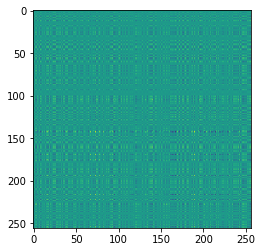

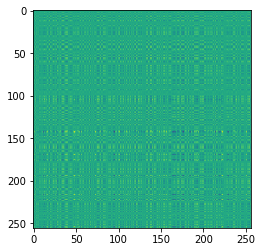

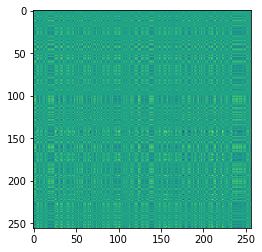

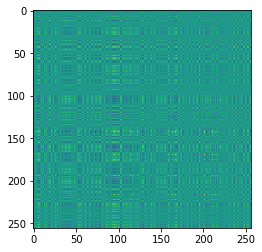

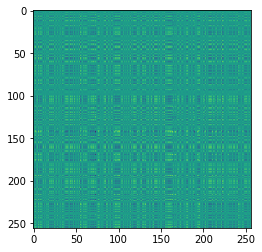

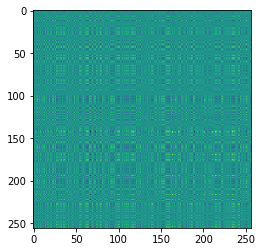

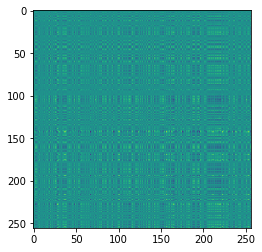

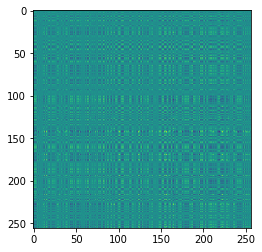

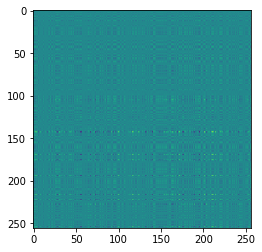

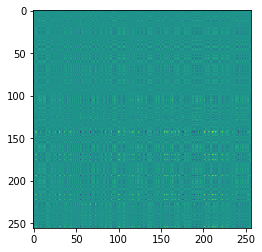

In [42]:
B, H, W = out.shape

x = out
for b in range(B):
    plt.imshow(x[b,:,:].cpu())
    plt.show()

# plt.tight_layout()